# TrkQualTrain.ipynb

The notebook to train the TrkQual algorithm. Note that this runs on TrkAna v4 trees

## User-defined parameters

Here are some common parameters that a new user may want to change

In [62]:
# User-defined parameters
output_modelname = 'TrkQual_ANN1_v2.0'
training_dataset_filename = "/Users/malikfarouh/Documents/ML workspace/ML model env/trkqual_tree_v2.0_training.root"
training_dataset_dirname = ""
training_dataset_treename = "trkqualtree"

In [63]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import xgboost     # not in pyana
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## Some useful functions

Here we declare some useful functions that will be used

### add_useful_columns
The ```add_useful_columns``` function is used to add some new columns to the awkward array

In [64]:
def add_useful_columns(batch):
    # Calculate magnitude of the momenta
    batch['trk_ent.mom'] = (batch['trk_ent.mom.fCoordinates.fX']**2 + batch['trk_ent.mom.fCoordinates.fY']**2 + batch['trk_ent.mom.fCoordinates.fZ']**2)**0.5
    batch['trk_ent_mc.mom'] = (batch['trk_ent_mc.mom.fCoordinates.fX']**2 + batch['trk_ent_mc.mom.fCoordinates.fY']**2 + batch['trk_ent_mc.mom.fCoordinates.fZ']**2)**0.5
    
    # For masks
    #batch['ent_fit_is_highmom'] = ak.flatten(ak.any( (batch['demfit.mom']>80) & (batch['demfit.sid']==0), axis=-1, keepdims=True))
    
    # For training features
    batch['trk.factive'] = batch['trk.nactive'] / batch['trk.nhits']
    batch['trk.fambig'] = batch['trk.nnullambig'] / batch['trk.nactive']
    batch['trk.fstraws'] = batch['trk.nmatactive'] / batch['trk.nactive']

### plot_loss

The ```plot_loss``` function will be used later after the model is trained

In [65]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss (training)')
  plt.plot(history.history['val_loss'], label='loss (validation)')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

## Things start for real here

We start filling some arrays with the data we want from the TrkAna tree

Now we organize our training features into the correct shape

In [66]:

import uproot
import awkward as ak
import numpy as np

# We will put the variables we want into numpy arrays
trk_ent_mom=[] # reco momentum at tracker entrance
trk_ent_mc_mom=[] # MC true momentum at tracker entrance
# The variables we need for the features we will train on

nactive=[]
factive=[]
t0err=[]
momerr=[]
fambig=[]
fitcon=[]
fstraws=[]

counter=0

trkqual_tree = uproot.open(training_dataset_filename+":"+training_dataset_treename)
print(training_dataset_filename.split('/')[-1].strip('\n') + ": "+str(trkqual_tree.num_entries)+" entries")
# Iterate through the entries in the file
for batch, report in trkqual_tree.iterate(step_size="10 MB", report=True, library='ak'):
    # Make some aliases for new columns
    add_useful_columns(batch)
    
    # Get the cut masks: one for the track dimensions (rows in the trkana tree), and one for the fit dimensions (we get multiple fits per track)
    track_mask = (batch['trk.status']>0) & (batch['trk.goodfit']==1) & ~np.isnan(batch['trk_ent_pars.t0err']) & (batch['trk_sim.startCode']==173)#167)#167) # & (batch['has_ent_fit']==True) & (batch['has_ent_mc']==True) & (batch['ent_fit_is_highmom']==True)
    #sim_mask = (batch['demmcsim.gen']==167)
    #fit_mask = (batch['.sid']==0) 
    #mc_mask = (batch['demmcvd.sid']==0) # we want the fit momentum at the entrance
            
    # Here we keep on appending to the arrays
    trk_ent_mom = np.append(trk_ent_mom, (batch['trk_ent.mom'][track_mask]).to_numpy())
    trk_ent_mc_mom = np.append(trk_ent_mc_mom, (batch['trk_ent_mc.mom'][track_mask]).to_numpy())
                
    nactive = np.append(nactive, (batch['trk.nactive'][track_mask]).to_numpy())
    factive = np.append(factive, (batch['trk.factive'][track_mask]).to_numpy())
    fambig = np.append(fambig, (batch['trk.fambig'][track_mask]).to_numpy())
    fstraws = np.append(fstraws, (batch['trk.fstraws'][track_mask]).to_numpy())
    #print(nactive)
            
    t0err = np.append(t0err, batch['trk_ent_pars.t0err'][track_mask].to_numpy())   
    fitcon = np.append(fitcon, (batch['trk.fitcon'][track_mask]).to_numpy())
    momerr = np.append(momerr, (batch['trk_ent.momerr'][track_mask]).to_numpy())

# Define high-quality and low-quality tracks
mom_res = trk_ent_mom - trk_ent_mc_mom
high_qual = (mom_res>-0.25) & (mom_res<0.25)
low_qual = (mom_res>0.7)

print("Batch length:", len(batch['trk.status']))
print("trk.status > 0:", np.sum(batch['trk.status'] > 0))
print("trk.goodfit == 1:", np.sum(batch['trk.goodfit'] == 1))
print("~np.isnan(trk_ent_pars.t0err):", np.sum(~np.isnan(batch['trk_ent_pars.t0err'])))
print("trk_sim.startCode == 167:", np.sum(batch['trk_sim.startCode'] == 167))

# Since this cell takes a while, we'll print to say that we're done
print("Done!")


trkqual_tree_v2.0_training.root: 452686 entries
Batch length: 6243
trk.status > 0: 6243
trk.goodfit == 1: 6243
~np.isnan(trk_ent_pars.t0err): 6243
trk_sim.startCode == 167: 0
Done!


In [67]:
print(np.unique(batch['trk_sim.startCode']))


[173]


In [68]:
print(len(nactive))
print(len(factive))
print(len(t0err))
print(len(fambig))
print(len(fitcon))
print(len(momerr))
print(len(fstraws))

452686
452686
452686
452686
452686
452686
452686


In [69]:
input_dataset=np.empty
temp = np.empty
temp = np.vstack((nactive, factive, t0err, fambig, fitcon, momerr, fstraws)).T
#print(temp)  Not included in the old one
if input_dataset is np.empty:
    input_dataset = temp
else:
    input_dataset = np.concatenate((input_dataset, temp))

input_var_names = ["nactive", "factive", "t0err", "fambig", "fitcon", "momerr", "fstraws"]
n_input_vars = len(input_dataset[0])

Now we plot the momentum resolution of the training sample with the high-quality and low-quality tracks highlighted

Text(0, 0.5, 'Number of Tracks')

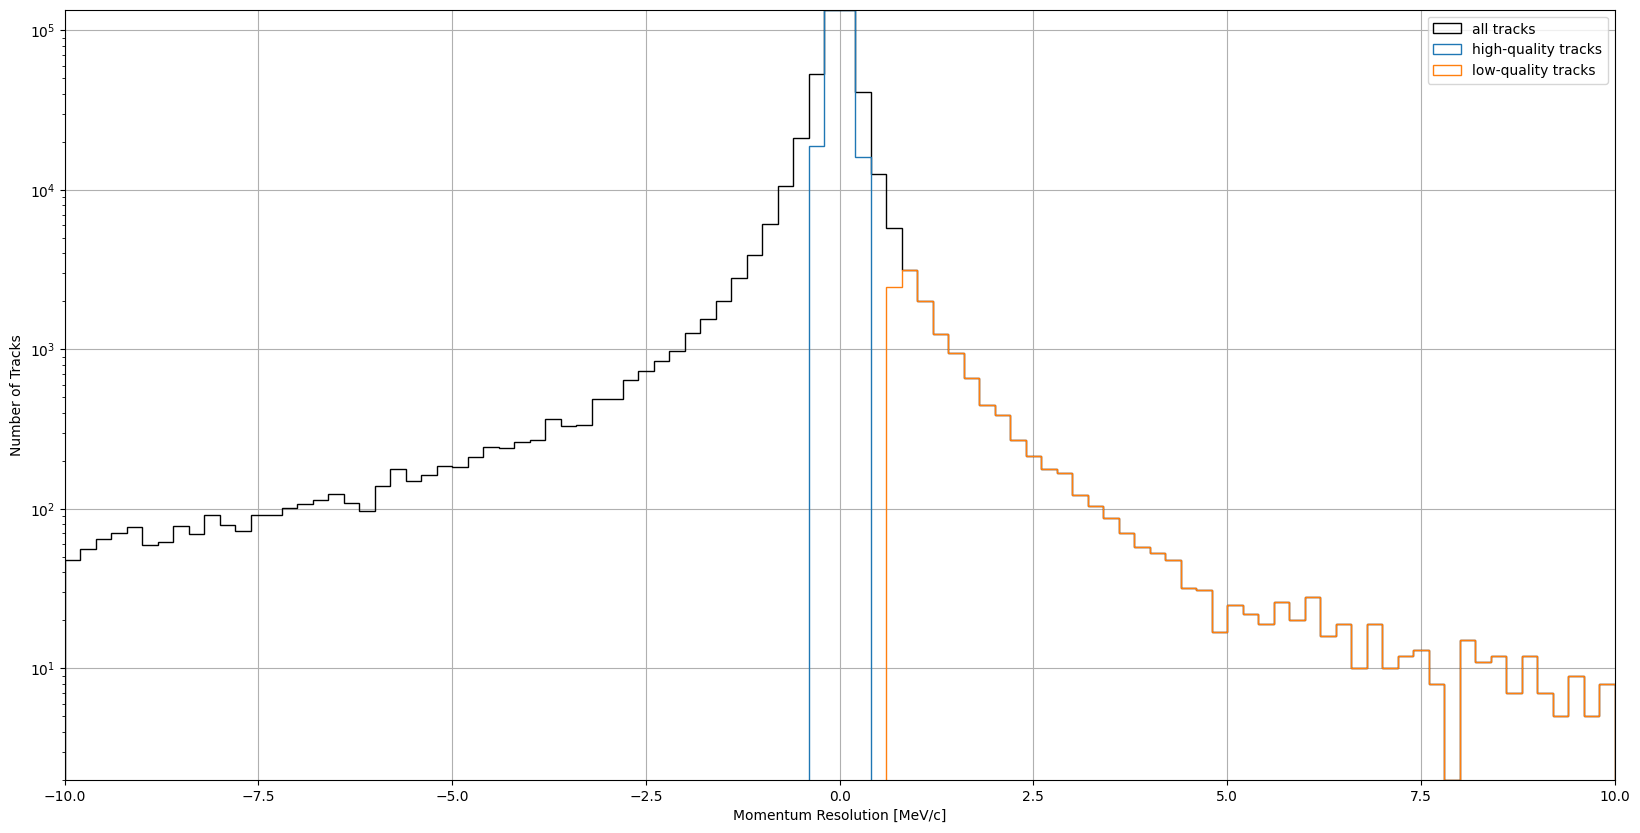

In [70]:
min_mom_res=-10
max_mom_res=10
n_mom_res_bins=100

fig, ax = plt.subplots(1, 1)
bins, counts, patches = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
bins, counts, patches = ax.hist(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='high-quality tracks')
bins, counts, patches = ax.hist(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='low-quality tracks')
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Here we plot all the training features. Note that we have used ```density=True``` so each histogram is normalized to unit area

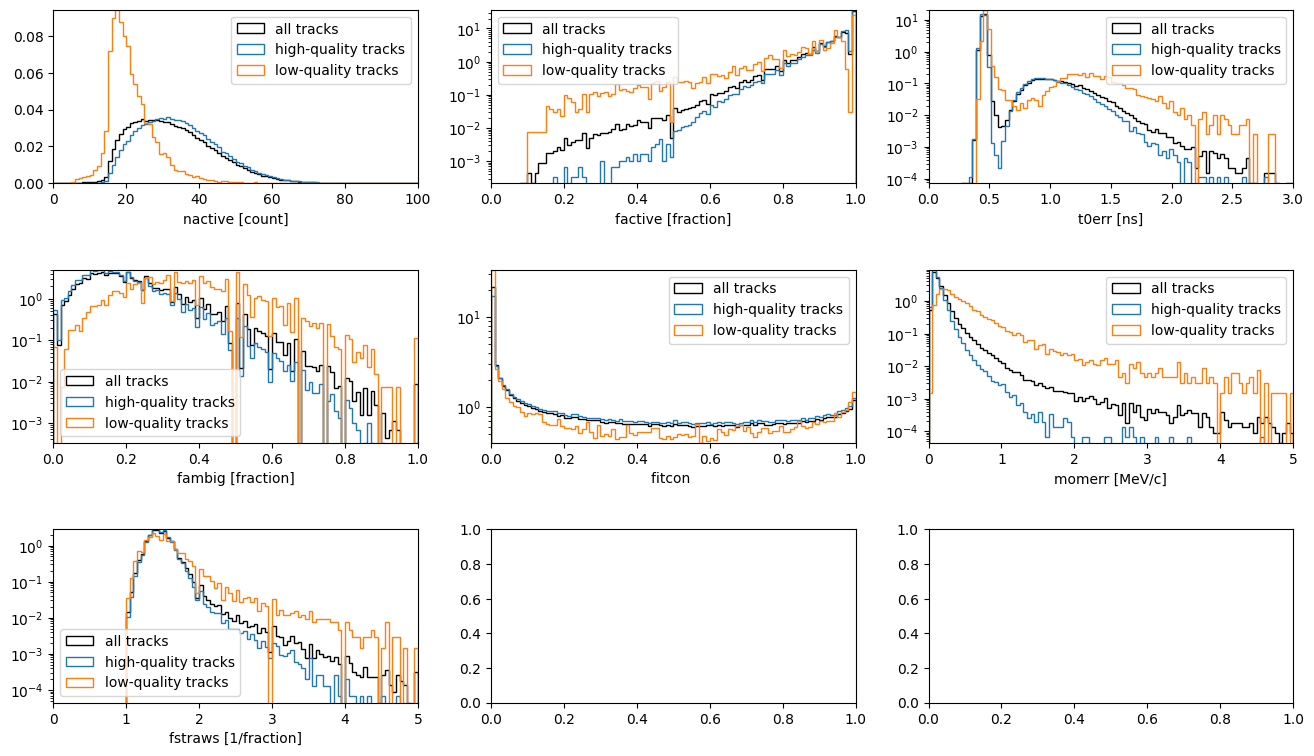

In [71]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
x_mins=[0, 0, 0, 0, 0, 0, 0]
x_maxs=[100, 1, 3, 1, 1, 5, 5]
log_ys=[False, True, True, True, True, True, True]
#log_ys=[False, False, False, False, False, False, False]
units=['[count]', '[fraction]', '[ns]', '[fraction]', '', '[MeV/c]', '[1/fraction]']
density=True
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='all tracks', density=density)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][high_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='high-quality tracks', density=density)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][low_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='low-quality tracks', density=density)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Now we balance the inputs since we don't have that many low-quality tracks to train on

In [72]:
# In this cell x_ variables are features, and y_ are the output results
min_len = min(len(input_dataset[high_qual]), len(input_dataset[low_qual]))

x_high_qual_dataset = input_dataset[high_qual][:min_len]
x_low_qual_dataset = input_dataset[low_qual][:min_len]

x_balanced_input = np.concatenate((x_high_qual_dataset, x_low_qual_dataset))
# set 1 to be high quality, and 0 to be low quality
y_balanced_input = np.concatenate((np.ones(x_high_qual_dataset.shape[0]), np.zeros(x_low_qual_dataset.shape[0])))

# split the dataset into train and test samples
x_train, x_test, y_train, y_test = train_test_split(x_balanced_input, y_balanced_input, test_size=0.5, random_state=42)
# further split the test sample, into testing and validation samples
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
print("N train = "+str(len(x_train)) + ", N test = "+str(len(x_test)) + ", N valid = "+str(len(x_valid)))

N train = 13449, N test = 6724, N valid = 6725


Here we plot the features for each of the training, testing, and validation samples. All these plots should look similar

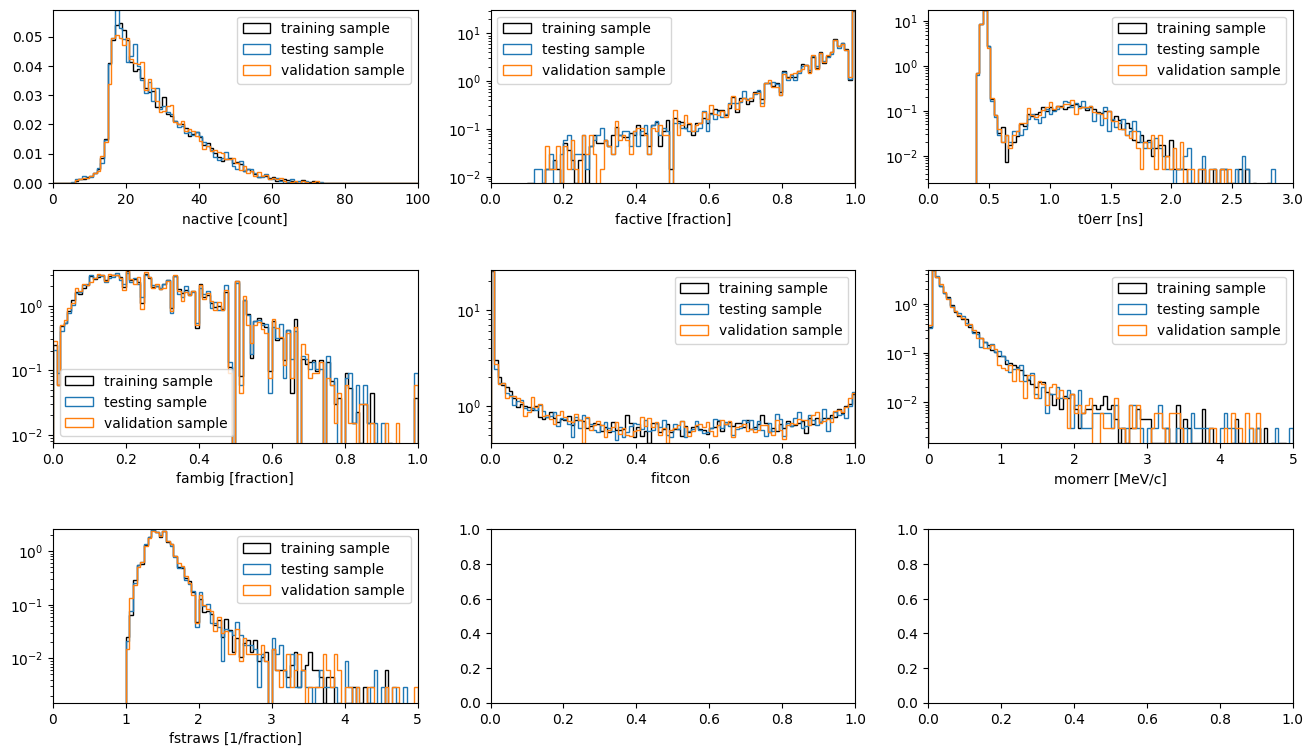

In [73]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(x_train[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='training sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_test[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='testing sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_valid[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='validation sample', density=True)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Here we now build the model and do the training. Here we are copying what was done in the old TrkQual. Namely:
 - N, N-1 neurons in the hidden layers
 - sigmoid activation functions
 - no dropout layers

Now get the predicted values for the input dataset (ideally, this would be a separate dataset)


Training with 10 trees...
  Final validation error: 0.1325
  Accuracy on validation: 0.8675

Training with 100 trees...
  Final validation error: 0.1246
  Accuracy on validation: 0.8754

Training with 500 trees...
  Final validation error: 0.1279
  Accuracy on validation: 0.8721

Training with 1000 trees...
  Final validation error: 0.1303
  Accuracy on validation: 0.8697

Training with 3000 trees...
  Final validation error: 0.1377
  Accuracy on validation: 0.8623


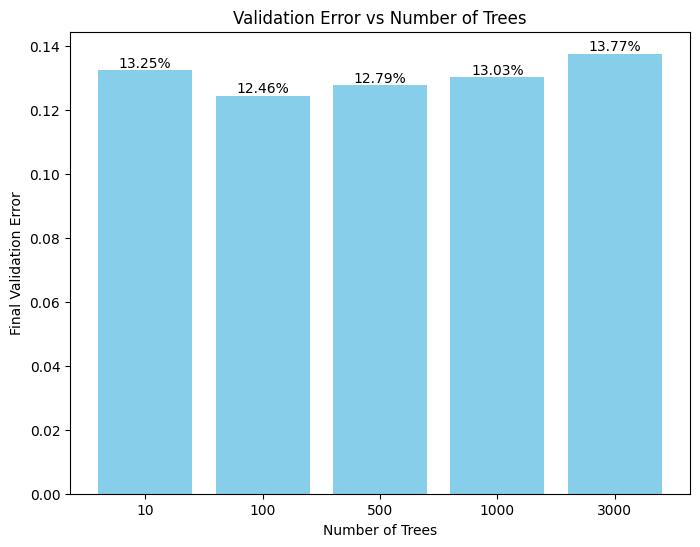

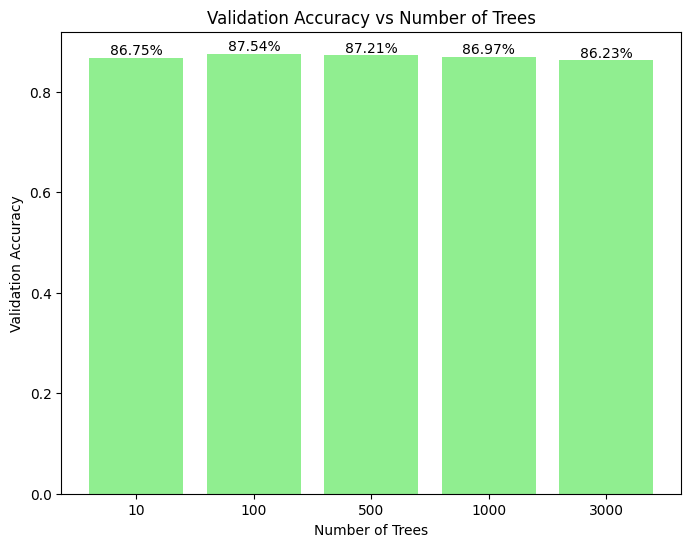

In [74]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
import joblib  # for saving model
import matplotlib.pyplot as plt

# Prepare the DMatrix objects (XGBoost’s internal data format)
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_valid, label=y_valid)

# Define parameters for a binary classification BDT
params = {
    "objective": "binary:logistic",
    "eval_metric": "error",   # <-- changed from logloss to error (misclassification rate)
    "max_depth": 4,
    "eta": 0.04,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.1,
    "gamma": 0.1
}

# Different numbers of trees to try
tree_counts = [10, 100, 500, 1000, 3000]

final_errors = [] 
final_accs = []

for n_rounds in tree_counts:
    print(f"\nTraining with {n_rounds} trees...")

    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=n_rounds,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # Predictions on validation set
    y_pred_prob = bst.predict(dvalid)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_valid, y_pred)
    err = evals_result["valid"]["error"][-1]   # last validation error
    
    final_errors.append(err)
    final_accs.append(acc)
    
    print(f"  Final validation error: {err:.4f}")
    print(f"  Accuracy on validation: {acc:.4f}")

# ---- Plot error bar chart ----
plt.figure(figsize=(8,6))
bars = plt.bar([str(n) for n in tree_counts], final_errors, color="skyblue")
plt.ylabel("Final Validation Error")
plt.xlabel("Number of Trees")
plt.title("Validation Error vs Number of Trees")

# Annotate values on bars
for bar, val in zip(bars, final_errors):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.2%}", ha='center', va='bottom', fontsize=10)

plt.show()

# ---- Plot accuracy bar chart ----
plt.figure(figsize=(8,6))
bars = plt.bar([str(n) for n in tree_counts], final_accs, color="lightgreen")
plt.ylabel("Validation Accuracy")
plt.xlabel("Number of Trees")
plt.title("Validation Accuracy vs Number of Trees")

# Annotate values on bars
for bar, val in zip(bars, final_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{val:.2%}", ha='center', va='bottom', fontsize=10)

plt.show()


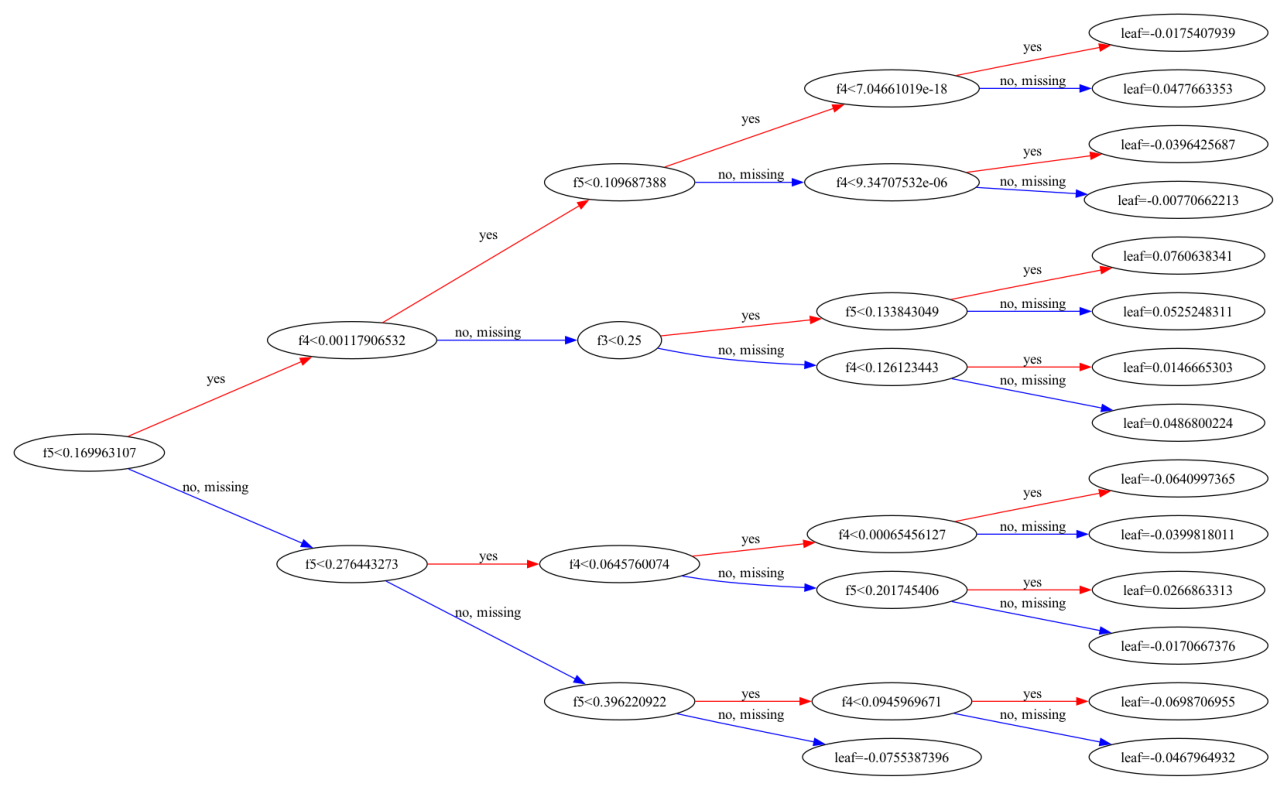

In [75]:
import matplotlib.pyplot as plt
import xgboost as xgb

# visualize the first tree (tree_index=0)
xgb.plot_tree(bst, num_trees=0, rankdir="LR")
plt.rcParams['figure.figsize'] = [20, 10]  # make it bigger
plt.show()

<Figure size 2000x1000 with 0 Axes>

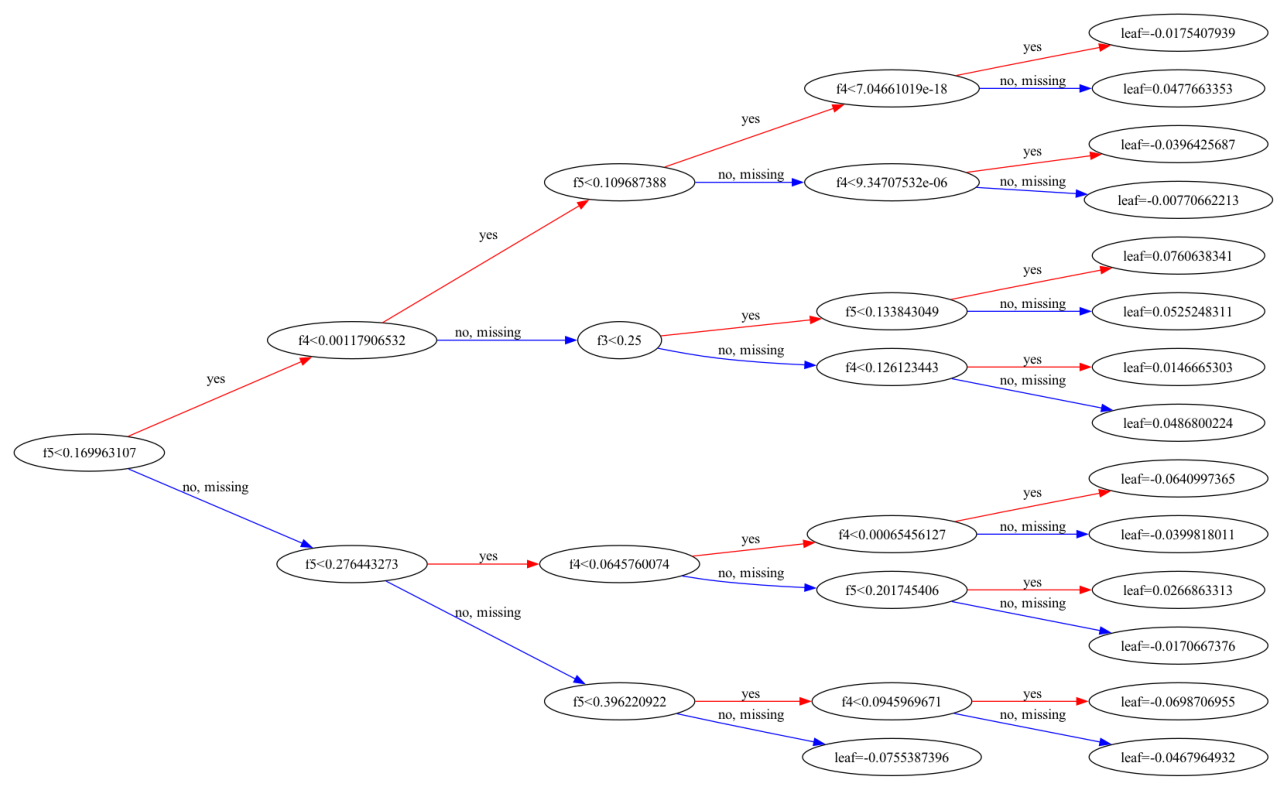

<Figure size 2000x1000 with 0 Axes>

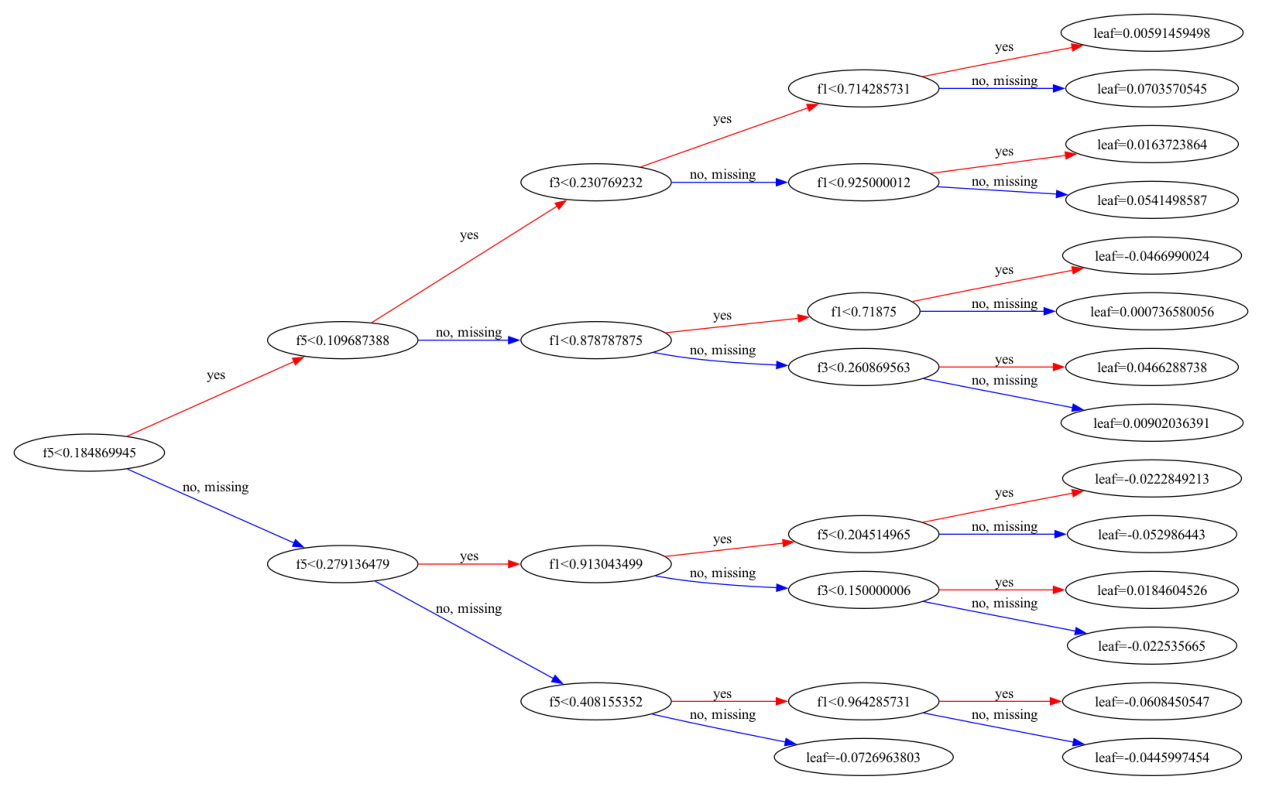

<Figure size 2000x1000 with 0 Axes>

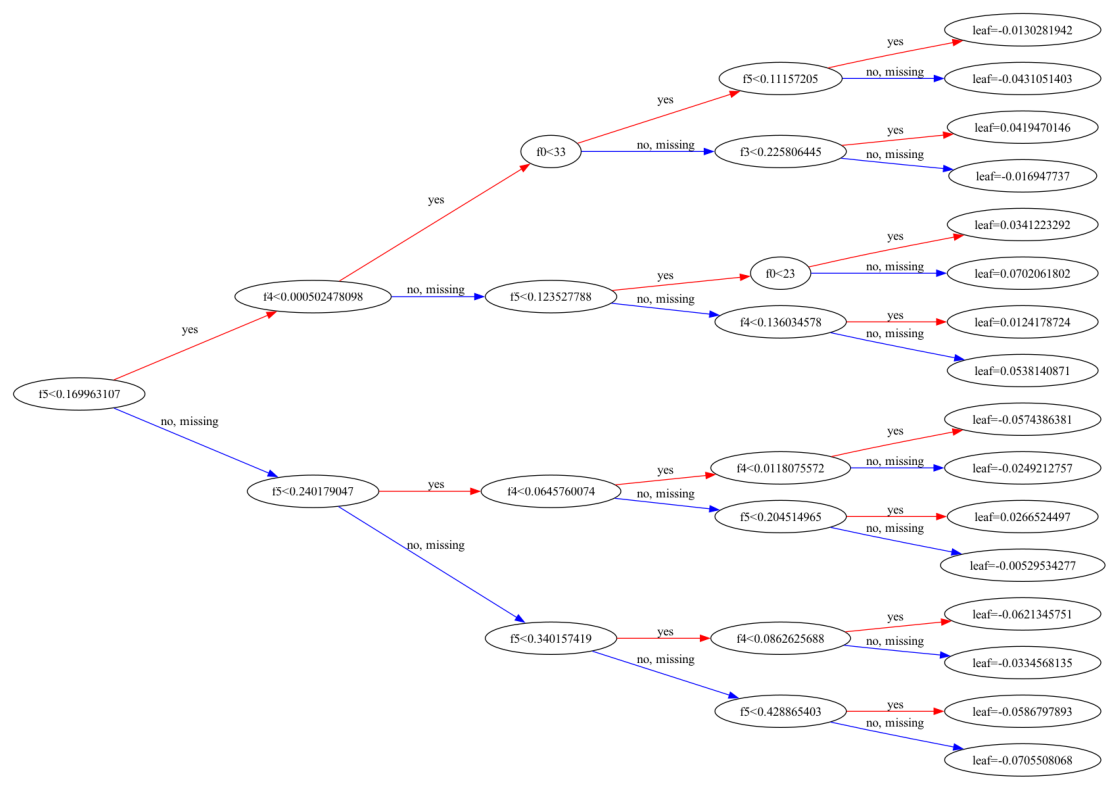

In [76]:
for i in range(3):  # visualize first 3 trees
    plt.figure(figsize=(20, 10))
    xgb.plot_tree(bst, num_trees=i, rankdir="LR")
    #plot_tree(bst, num_trees=i, rankdir="LR")
    plt.show()



Training with 10 trees...
  Accuracy on validation: 0.8675 ± 0.0041

Training with 100 trees...
  Accuracy on validation: 0.8754 ± 0.0040

Training with 500 trees...
  Accuracy on validation: 0.8721 ± 0.0041

Training with 1000 trees...
  Accuracy on validation: 0.8697 ± 0.0041

Training with 3000 trees...
  Accuracy on validation: 0.8623 ± 0.0042


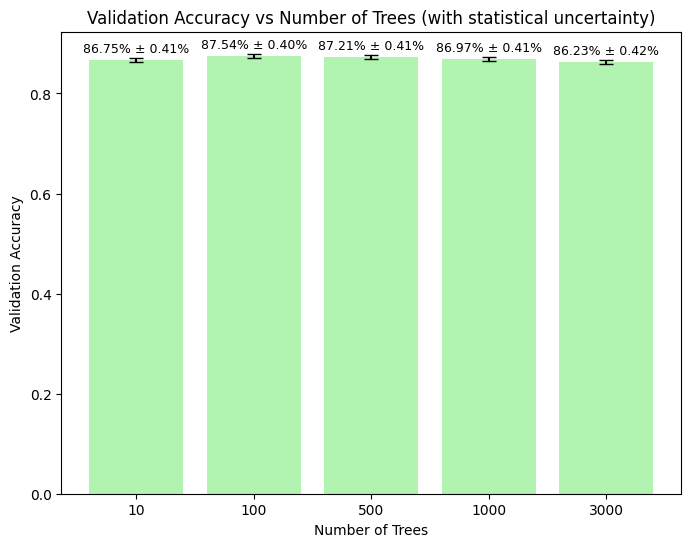

In [77]:
from math import sqrt

final_errors = [] 
final_accs = []
final_uncertainties = []

N = len(y_valid)  # number of validation samples

for n_rounds in tree_counts:
    print(f"\nTraining with {n_rounds} trees...")

    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=n_rounds,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # Predictions on validation set
    y_pred_prob = bst.predict(dvalid)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_valid, y_pred)
    err = evals_result["valid"]["error"][-1]
    
    # statistical uncertainty (binomial standard error)
    sigma_acc = sqrt(acc * (1 - acc) / N)
    
    final_errors.append(err)
    final_accs.append(acc)
    final_uncertainties.append(sigma_acc)
    
    print(f"  Accuracy on validation: {acc:.4f} ± {sigma_acc:.4f}")

# ---- Plot accuracy with error bars ----
plt.figure(figsize=(8,6))
plt.bar([str(n) for n in tree_counts], final_accs, yerr=final_uncertainties, 
        capsize=5, color="lightgreen", alpha=0.7)
plt.ylabel("Validation Accuracy")
plt.xlabel("Number of Trees")
plt.title("Validation Accuracy vs Number of Trees (with statistical uncertainty)")

# Annotate with percentage and uncertainty
for i, (acc, sigma) in enumerate(zip(final_accs, final_uncertainties)):
    plt.text(i, acc + sigma + 0.005, f"{acc:.2%} ± {sigma:.2%}", 
             ha='center', va='bottom', fontsize=9)

plt.show()


In [78]:
dinput = xgb.DMatrix(input_dataset)
output_trkqual = bst.predict(dinput)  # probabilities between 0 and 1
trkqual = np.array(output_trkqual)    # keep same shape as before

Now we save the model

In [79]:
joblib.dump(bst, "model/" + output_modelname + ".joblib")
# Later load with: bst = joblib.load("model/xxx.joblib")    

['model/TrkQual_ANN1_v2.0.joblib']

### Some Validation Plots

Here is the loss as a function of epoch for the training and validation datasets

In [80]:
import matplotlib.pyplot as plt


def plot_loss(evals_result):
    """
    Plots training and validation loss from XGBoost.
    
    evals_result: dictionary returned by xgb.train with evals_result=evals_result
    """
    train_loss = evals_result['train']['logloss']
    valid_loss = evals_result['valid']['logloss']

    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label="train")
    plt.plot(valid_loss, label="validation")
    plt.xlabel("Boosting round")
    plt.ylabel("Logloss")
    plt.title("Training vs Validation Loss (XGBoost)")
    plt.legend()
    plt.show()

Here we get the ROC curve, as well as the cut value that rejects 99% of low-quality tracks. (For a real analysis, we would find a different optimization procedure)

10 trees: trkqual_cut=0.6399999856948853, signal eff=52.7%, background rej=99.0%
100 trees: trkqual_cut=0.8999999761581421, signal eff=57.5%, background rej=99.0%
500 trees: trkqual_cut=0.9100000262260437, signal eff=60.7%, background rej=99.0%
1000 trees: trkqual_cut=0.9100000262260437, signal eff=61.2%, background rej=99.0%
3000 trees: trkqual_cut=0.9599999785423279, signal eff=60.7%, background rej=99.0%


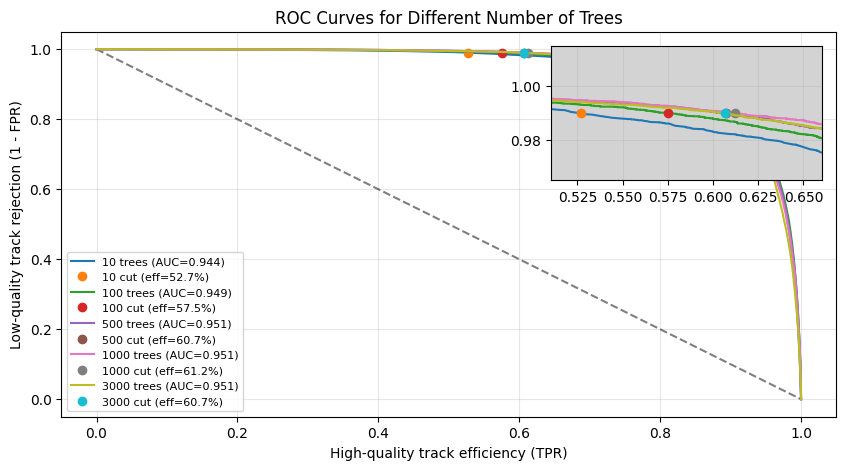

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# -----------------------------
# Balance training data
# -----------------------------
def balance_training_data(x_train, y_train):
    x_0 = x_train[y_train == 0]
    x_1 = x_train[y_train == 1]
    y_0 = y_train[y_train == 0]
    y_1 = y_train[y_train == 1]
    
    if len(x_0) < len(x_1):
        x_0_bal, y_0_bal = resample(x_0, y_0, replace=True, n_samples=len(x_1), random_state=42)
        x_bal = np.vstack([x_0_bal, x_1])
        y_bal = np.concatenate([y_0_bal, y_1])
    else:
        x_1_bal, y_1_bal = resample(x_1, y_1, replace=True, n_samples=len(x_0), random_state=42)
        x_bal = np.vstack([x_0, x_1_bal])
        y_bal = np.concatenate([y_0, y_1_bal])
    
    indices = np.random.RandomState(42).permutation(len(x_bal))
    return x_bal[indices], y_bal[indices]

# -----------------------------
# Get XGBoost parameters
# -----------------------------
def get_better_params(y_train):
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.04,
        'max_depth': 5,
        'min_child_weight': 1,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42
    }
    return params

# -----------------------------
# Prepare data
# -----------------------------
x_train_bal, y_train_bal = balance_training_data(x_train, y_train)
dtrain = xgb.DMatrix(x_train_bal, label=y_train_bal)
dvalid = xgb.DMatrix(x_valid, label=y_valid)
params = get_better_params(y_train_bal)

tree_counts = [10, 100, 500, 1000, 3000]

# -----------------------------
# ROC plot setup
# -----------------------------
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.plot([0, 1], [1, 0], 'k--', alpha=0.5)

roc_data = {}

# -----------------------------
# Train models, compute ROC, plot
# -----------------------------
for n_rounds in tree_counts:
    # Train model
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=n_rounds,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=False
    )
    
    # Full dataset (high + low quality)
    y_full = np.concatenate((
        np.ones(input_dataset[high_qual].shape[0]),
        np.zeros(input_dataset[low_qual].shape[0])
    ))
    x_full = np.concatenate((
        input_dataset[high_qual],
        input_dataset[low_qual]
    ))
    dfull = xgb.DMatrix(x_full)
    
    # Predict probabilities
    y_pred_prob = bst.predict(dfull)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_full, y_pred_prob, pos_label=1)
    auc_score = auc(fpr, tpr)
    
    # Find cut point for 99% background rejection
    rej_target = 0.99
    indices = np.where(1 - fpr >= rej_target)[0]
    cut_idx = indices[-1] if len(indices) > 0 else 0
    sig_eff = tpr[cut_idx]
    trkqual_cut = round(thresholds[cut_idx], 2)
    
    roc_data[n_rounds] = (fpr, tpr, cut_idx)
    
    print(f"{n_rounds} trees: trkqual_cut={trkqual_cut}, signal eff={sig_eff*100:.1f}%, background rej={(1-fpr[cut_idx])*100:.1f}%")
    
    # Plot ROC + cut point
    ax.plot(tpr, 1 - fpr, label=f"{n_rounds} trees (AUC={auc_score:.3f})")
    ax.plot(tpr[cut_idx], 1 - fpr[cut_idx], 'o', label=f"{n_rounds} cut (eff={sig_eff*100:.1f}%)")

# -----------------------------
# Main plot settings
# -----------------------------
ax.set_xlabel("High-quality track efficiency (TPR)")
ax.set_ylabel("Low-quality track rejection (1 - FPR)")
ax.set_title("ROC Curves for Different Number of Trees")
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# -----------------------------
# Inset plot (zoom around cut points)
# -----------------------------
cut_tpr = [roc_data[n][1][roc_data[n][2]] for n in tree_counts]
cut_rej = [1 - roc_data[n][0][roc_data[n][2]] for n in tree_counts]

mean_tpr = np.mean(cut_tpr)
mean_rej = np.mean(cut_rej)

axins = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=1.0)
axins.set_facecolor("lightgray")

# Plot curves + cut dots in inset
for n_rounds in tree_counts:
    fpr, tpr, cut_idx = roc_data[n_rounds]
    axins.plot(tpr, 1 - fpr)
    axins.plot(tpr[cut_idx], 1 - fpr[cut_idx], 'o')

# Zoom ranges
zoom_x = 0.15
zoom_y = 0.05
axins.set_xlim(mean_tpr - zoom_x/2, mean_tpr + zoom_x/2)
axins.set_ylim(mean_rej - zoom_y/2, mean_rej + zoom_y/2)
axins.grid(alpha=0.3)

plt.show()


## Results

Now we make the main plot: the momentum resolution with the trkqual cut we found for 99% low-quality track rejection

Text(0, 0.5, 'Number of Tracks')

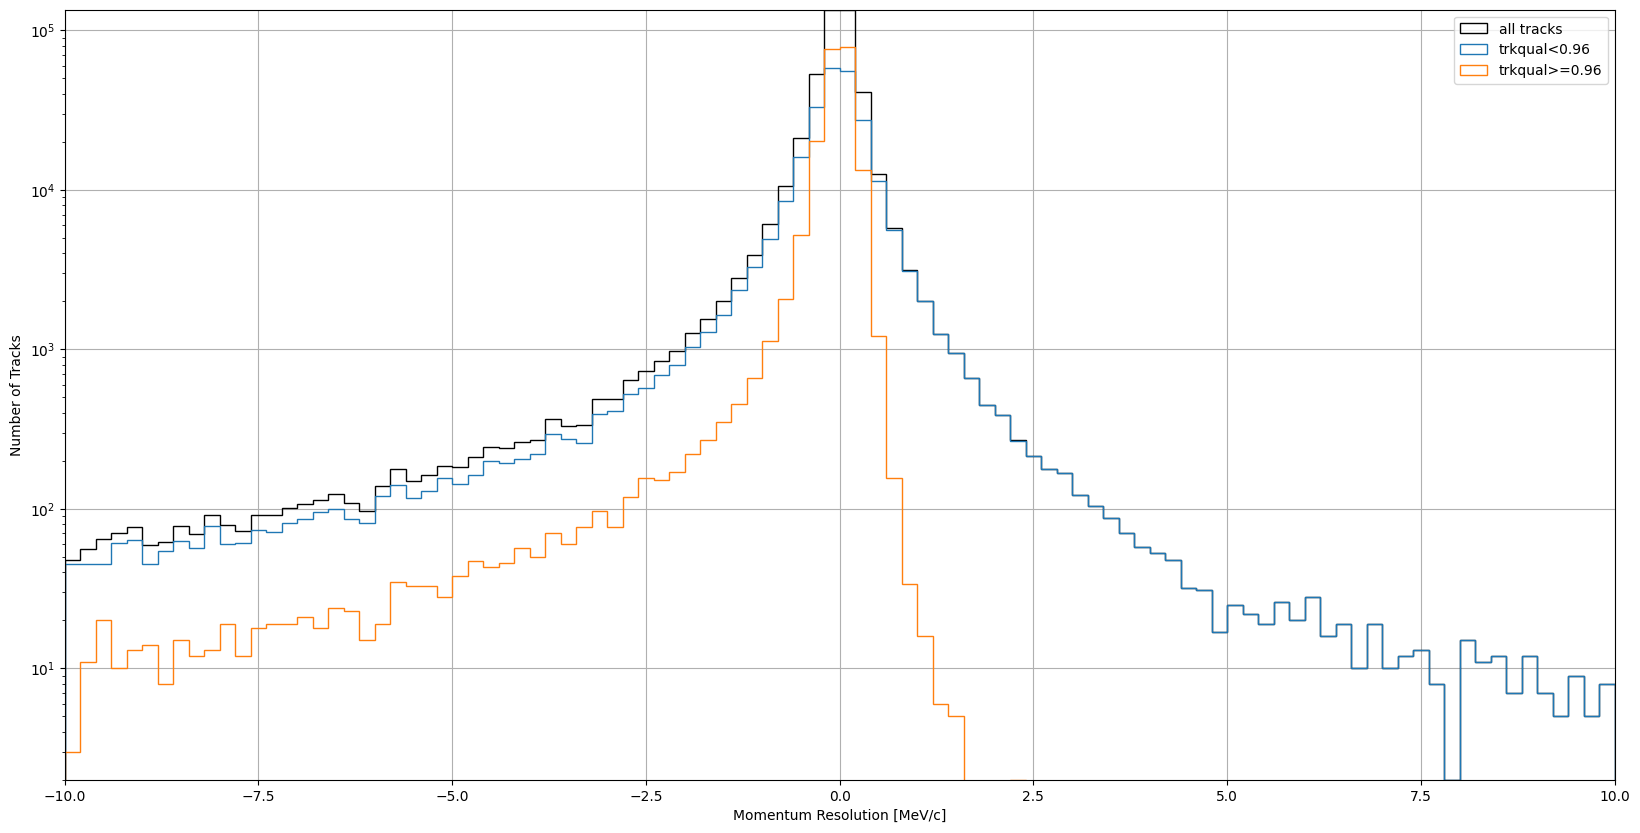

In [82]:
fig, ax = plt.subplots(1,1)
_, _, _, = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
_, _, _, = ax.hist(mom_res[trkqual<trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual<'+str(trkqual_cut))
_, _, _, = ax.hist(mom_res[trkqual>=trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual>='+str(trkqual_cut))
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Text(7.1, 0.5, 'low-quality tracks')

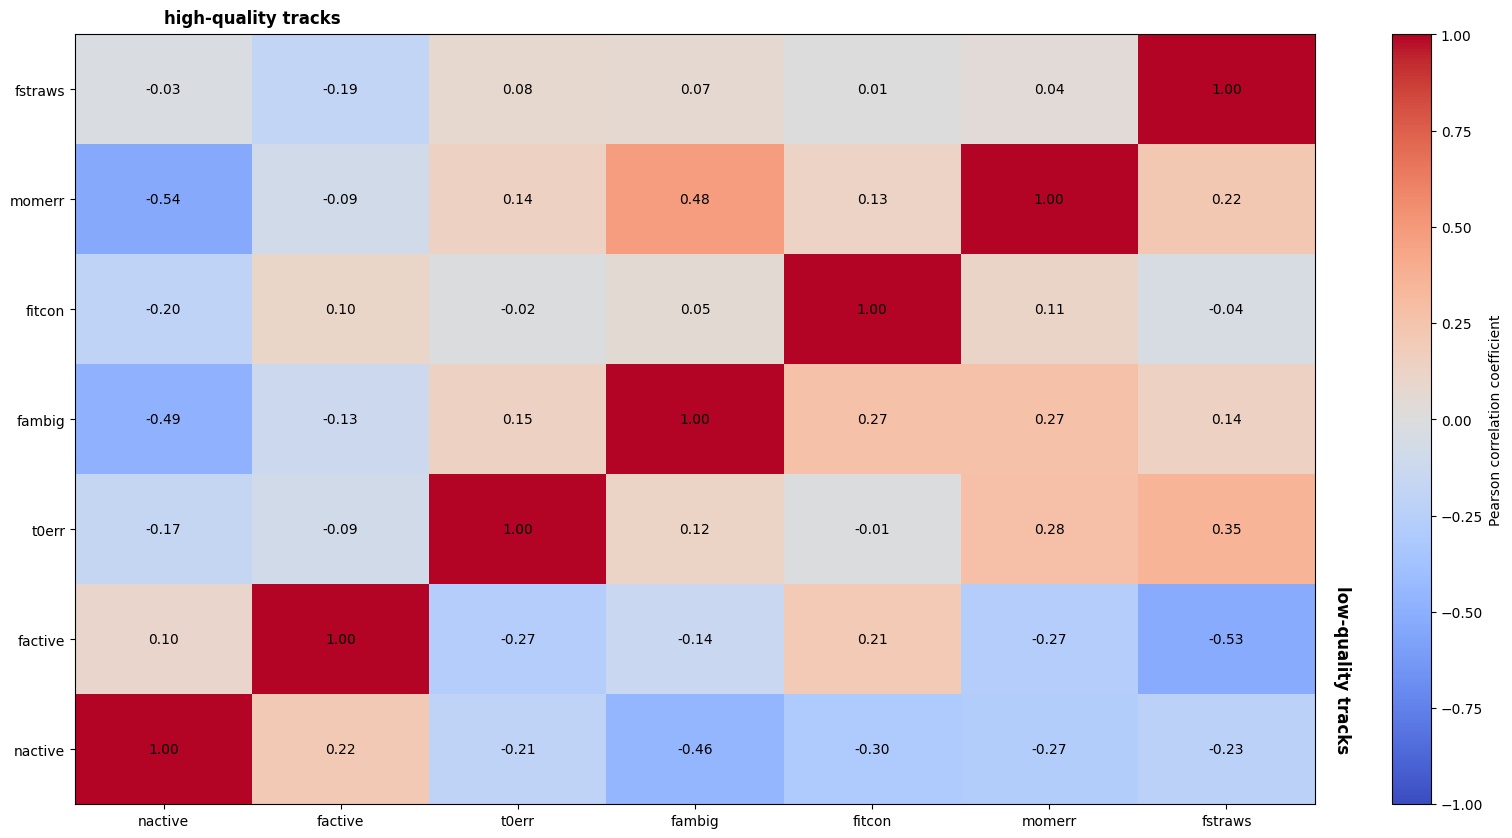

In [83]:
qualities = [ high_qual, low_qual ]
qual_labels = ["high", "low"]

xs = np.linspace(0,n_input_vars-1,n_input_vars)
ys = xs
x_corrs=[]
y_corrs=[]
corrs=[]#np.ndarray((n_input_vars,n_input_vars))
for qual_label,quality in zip(qual_labels,qualities):
    for i_x,x in enumerate(xs):
        x_i = input_dataset[:,i_x][quality]
        mean_x = np.mean(x_i)
        for i_y,y in enumerate(ys):
            if qual_label=="high":
                if (y<x):
                    continue
            elif qual_label=="low":
                if (y>=x):
                    continue
            y_i = input_dataset[:,i_y][quality]
            mean_y = np.mean(y_i)
            corr =  ( np.sum((x_i-mean_x)*(y_i - mean_y)) ) / ((np.sqrt(np.sum((x_i-mean_x)**2)))*(np.sqrt(np.sum((y_i-mean_y)**2))))
            x_corrs.append(x+0.5)
            y_corrs.append(y+0.5)
            corrs.append(corr)

#print(x_corrs)
#print(corrs)
H, xedges, yedges = np.histogram2d(x_corrs, y_corrs, bins=np.linspace(0,n_input_vars,n_input_vars+1), weights=corrs)
X, Y = np.meshgrid(xedges, yedges)
heatmap = plt.pcolormesh(Y, X, H, cmap='coolwarm')
cbar = plt.colorbar(heatmap)
plt.clim(-1,1)
_ = plt.xticks(xs+0.5, input_var_names)
_ = plt.yticks(ys+0.5, input_var_names)
cbar.ax.set_ylabel("Pearson correlation coefficient")
#print(yedges[:-1])
for x,y,corr in zip(x_corrs,y_corrs,corrs):
    if (abs(corr)>0.0):
        plt.text(x, y, '%.2f' % corr,
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.text(0.5, 7.1, "high-quality tracks", fontsize='large', fontweight='bold')#, horizontalalignment='center')#, rotation=45)
plt.text(7.1, 0.5, "low-quality tracks", fontsize='large', fontweight='bold', rotation=-90)#, verticalalignment='center', rotation=-90)

In [84]:
# Write out all histograms and plots to a ROOT file for future reference
outfile = uproot.recreate(output_modelname+"_plots.root")

# Momentum resolution plots
mom_res_hist_all = np.histogram(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["all_mom_res"] = mom_res_hist_all
mom_res_hist_high_qual = np.histogram(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["high_qual_mom"] = mom_res_hist_high_qual
mom_res_hist_low_qual = np.histogram(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["low_qual_mom_res"] = mom_res_hist_low_qual
mom_res_hist_pass = np.histogram(mom_res[(trkqual>=trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["pass_mom_res"] = mom_res_hist_pass
mom_res_hist_fail = np.histogram(mom_res[(trkqual<trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["fail_mom_res"] = mom_res_hist_fail

# datasets (input, train, text, and valid)
datasets=[input_dataset, input_dataset, input_dataset, x_train, x_test, x_valid, input_dataset, input_dataset]
prefixes = ["all_", "high_qual_", "low_qual_", "train_", "test_", "valid_", "pass_", "fail_"]
cuts = [(), (high_qual), (low_qual), (), (), (), (trkqual>=trkqual_cut), (trkqual<trkqual_cut)]
# Feature histograms
for dataset,prefix,cut in zip(datasets, prefixes, cuts):
    for i_var in range(0, n_input_vars):
        feature_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]))
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]] = feature_all
        feature_norm_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]), density=True)
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]+"_norm"] = feature_norm_all

#import pandas as pd
#df = pd.DataFrame({"tpr" : tpr_keras, "fpr" : fpr_keras, "thresh" : thresholds_keras})
#outfile["roc_curve"] = df

outfile["corr_matrix"] = H,xedges,yedges

In [85]:
import keras
print(keras.__version__)

3.10.0
